In [16]:
import act
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors



In [3]:
username = 'collis'
token = '6da84b44781397d7'

In [10]:
startdate = '2024-05-07T00:00:00'
enddate = '2024-05-07T23:00:00'


datastream = 'kcgdlfptM1.b1'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
ds_met = act.io.arm.read_arm_netcdf(result)

[DOWNLOADING] kcgdlfptM1.b1.20240507.120016.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.110016.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.010043.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.170017.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.220017.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.210016.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.020045.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.150016.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.180017.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.060017.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.030046.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.190017.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.050055.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.040053.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.090016.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.200015.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.100016.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.080016.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.070017.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.160015.cdf
[DOWNLOADING] kcgdlfptM1.b1.20240507.140

In [11]:
ds_met

<xarray.Dataset> Size: 238MB
Dimensions:                 (time: 45845, range: 320)
Coordinates:
  * time                    (time) datetime64[ns] 367kB 2024-05-07T00:00:41.4...
  * range                   (range) float32 1kB 15.0 45.0 ... 9.585e+03
Data variables: (12/13)
    base_time               (time) datetime64[ns] 367kB 2024-05-07 ... 2024-0...
    time_offset             (time) datetime64[ns] 367kB 2024-05-07T00:00:41.4...
    azimuth                 (time) float32 183kB dask.array<chunksize=(1997,), meta=np.ndarray>
    elevation               (time) float32 183kB dask.array<chunksize=(1997,), meta=np.ndarray>
    radial_velocity         (time, range) float32 59MB dask.array<chunksize=(1997, 320), meta=np.ndarray>
    qc_radial_velocity      (time, range) int32 59MB dask.array<chunksize=(1997, 320), meta=np.ndarray>
    ...                      ...
    attenuated_backscatter  (time, range) float32 59MB dask.array<chunksize=(1997, 320), meta=np.ndarray>
    pitch                   (time) float32 183kB dask.array<chunksize=(1997,), meta=np.ndarray>
    roll                    (time) float32 183kB dask.array<chunksize=(1997,), meta=np.ndarray>
    lat                     (time) float64 367kB -40.68 -40.68 ... -40.68 -40.68
    lon                     (time) float64 367kB 144.7 144.7 ... 144.7 144.7
    alt                     (time) float64 367kB 78.0 78.0 78.0 ... 78.0 78.0
Attributes: (12/30)
    command_line:                dl_ingest -s kcg -f M1
    Conventions:                 ARM-1.3
    process_version:             ingest-dl-2.30-0.el7
    dod_version:                 dlfpt-b1-1.3
    input_source:                /data/collection/kcg/kcgdlM1.00/Stare_160_20...
    site_id:                     kcg
    ...                          ...
    target_altitude:             78.000000
    history:                     created by user dsmgr on machine prod-proc4....
    _file_dates:                 ['20240507', '20240507', '20240507', '202405...
    _file_times:                 ['000041', '010043', '020045', '030046', '04...
    _datastream:                 kcgdlfptM1.b1
    _arm_standards_flag:         1

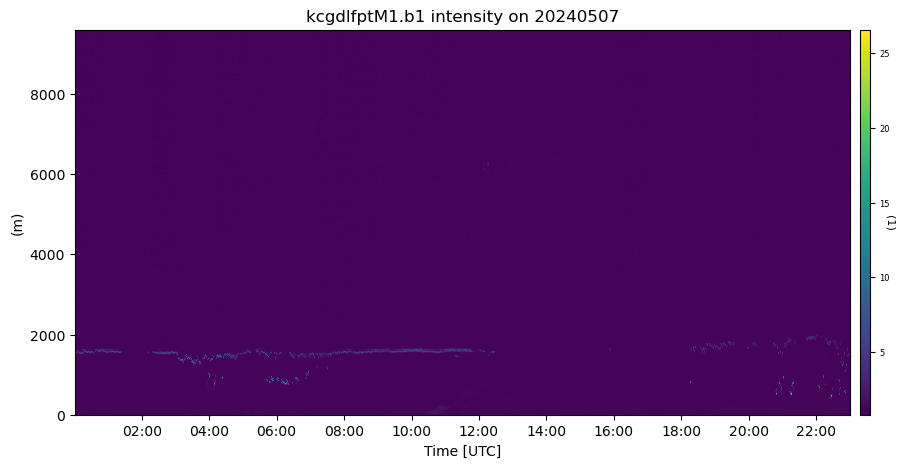

In [12]:
variable = 'intensity'
ds_met.clean.cleanup()
display = act.plotting.TimeSeriesDisplay(ds_met, figsize=(10, 5), subplot_shape=(1,))

# Plot up the variable in the first plot
display.plot(variable, subplot_index=(0,))

# Plot up the QC variable in the second plot
#display.qc_flag_block_plot(variable, subplot_index=(1,))
plt.show()


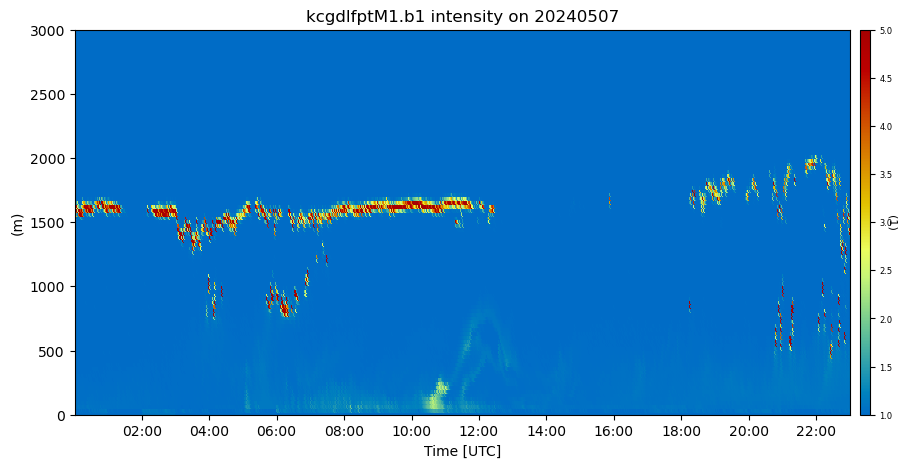

In [22]:
variable = 'intensity'
ds_met.clean.cleanup()
display = act.plotting.TimeSeriesDisplay(ds_met, figsize=(10, 5), subplot_shape=(1,))

# Plot up the variable in the first plot
display.plot(variable, subplot_index=(0,), cmap='HomeyerRainbow', vmin=1, vmax=5)
display.set_yrng([0, 3000], subplot_index=(0,))

# Plot up the QC variable in the second plot
#display.qc_flag_block_plot(variable, subplot_index=(1,))
plt.show()



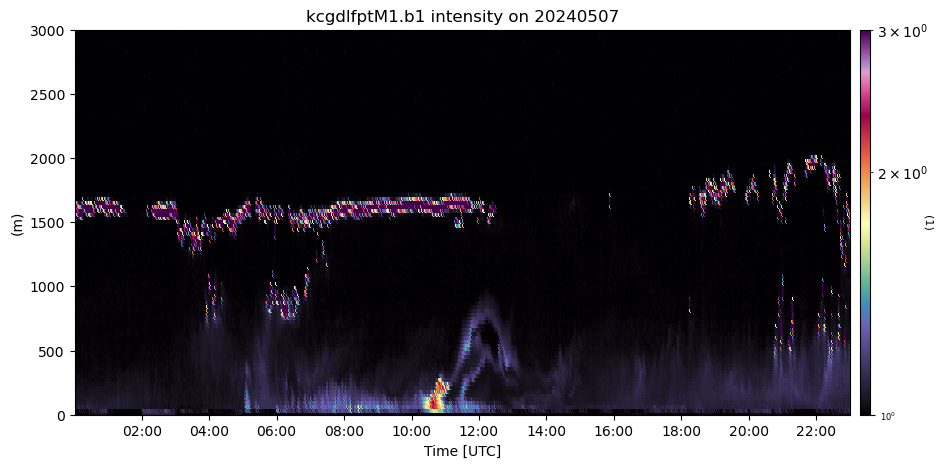

In [25]:
variable = 'intensity'
ds_met.clean.cleanup()
display = act.plotting.TimeSeriesDisplay(ds_met, figsize=(10, 5), subplot_shape=(1,))

# Plot up the variable in the first plot
display.plot(variable, subplot_index=(0,), cmap='ChaseSpectral', norm=colors.LogNorm(vmin=1, vmax=3))
display.set_yrng([0, 3000], subplot_index=(0,))

# Plot up the QC variable in the second plot
#display.qc_flag_block_plot(variable, subplot_index=(1,))
plt.show()



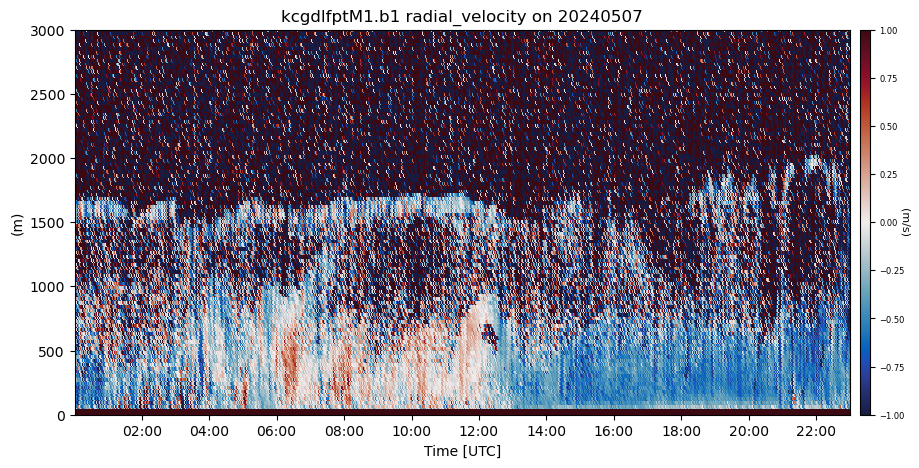

In [26]:
variable = 'radial_velocity'
ds_met.clean.cleanup()
display = act.plotting.TimeSeriesDisplay(ds_met, figsize=(10, 5), subplot_shape=(1,))

# Plot up the variable in the first plot
display.plot(variable, subplot_index=(0,), cmap='balance', vmin=-1, vmax=1)
display.set_yrng([0, 3000], subplot_index=(0,))

# Plot up the QC variable in the second plot
#display.qc_flag_block_plot(variable, subplot_index=(1,))
plt.show()



In [30]:
startdate = '2024-05-07T00:00:00'
enddate = '2024-05-07T23:00:00'


datastream = 'kcgmwacrcfrM1.a1'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
ds_wacr = act.io.arm.read_arm_netcdf(result)

[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.045959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.225958.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.145958.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.015959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.125958.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.165959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.195959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.115959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.005959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.085958.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.075959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.205958.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.055959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.025959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.155959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.035959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.095959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.105959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.215959.nc
[DOWNLOADING] kcgmwacrcfrM1.a1.20240507.175959.nc


In [31]:
ds_wacr

<xarray.Dataset> Size: 1GB
Dimensions:                             (time: 71627, range: 605, sweep: 1,
                                         r_calib: 1, frequency: 1)
Coordinates:
  * time                                (time) datetime64[ns] 573kB 2024-05-0...
  * frequency                           (frequency) float32 4B 9.504e+10
  * range                               (range) float32 2kB 153.2 ... 1.826e+04
    azimuth                             (time) float32 287kB dask.array<chunksize=(3114,), meta=np.ndarray>
    elevation                           (time) float32 287kB dask.array<chunksize=(3114,), meta=np.ndarray>
Dimensions without coordinates: sweep, r_calib
Data variables: (12/60)
    base_time                           (time) datetime64[ns] 573kB 2024-05-0...
    time_offset                         (time) datetime64[ns] 573kB 2024-05-0...
    mean_doppler_velocity               (time, range) float32 173MB dask.array<chunksize=(3114, 605), meta=np.ndarray>
    mean_doppler_velocity_crosspolar_v  (time, range) float32 173MB dask.array<chunksize=(3114, 605), meta=np.ndarray>
    reflectivity                        (time, range) float32 173MB dask.array<chunksize=(3114, 605), meta=np.ndarray>
    reflectivity_crosspolar_v           (time, range) float32 173MB dask.array<chunksize=(3114, 605), meta=np.ndarray>
    ...                                  ...
    longitude                           (time) float32 287kB dask.array<chunksize=(3114,), meta=np.ndarray>
    altitude                            (time) float32 287kB dask.array<chunksize=(3114,), meta=np.ndarray>
    altitude_agl                        (time) float32 287kB dask.array<chunksize=(3114,), meta=np.ndarray>
    lat                                 (time) float32 287kB dask.array<chunksize=(3114,), meta=np.ndarray>
    lon                                 (time) float32 287kB dask.array<chunksize=(3114,), meta=np.ndarray>
    alt                                 (time) float32 287kB dask.array<chunksize=(3114,), meta=np.ndarray>
Attributes: (12/35)
    command_line:                 mwacrcfr_ingest -s kcg -f M1
    Conventions:                  ARM-1.2 CF/Radial-1.4 instrument_parameters...
    process_version:              ingest-mwacrcfr-1.5-0.el7
    dod_version:                  mwacrcfr-a1-1.0
    input_source:                 /data/collection/kcg/kcgmwacrM1.00/MWACR_MO...
    site_id:                      kcg
    ...                           ...
    doi:                          10.5439/1512077
    history:                      created by user dsmgr on machine prod-proc4...
    _file_dates:                  ['20240507', '20240507', '20240507', '20240...
    _file_times:                  ['005959', '015959', '025959', '035959', '0...
    _datastream:                  kcgmwacrcfrM1.a1
    _arm_standards_flag:          1

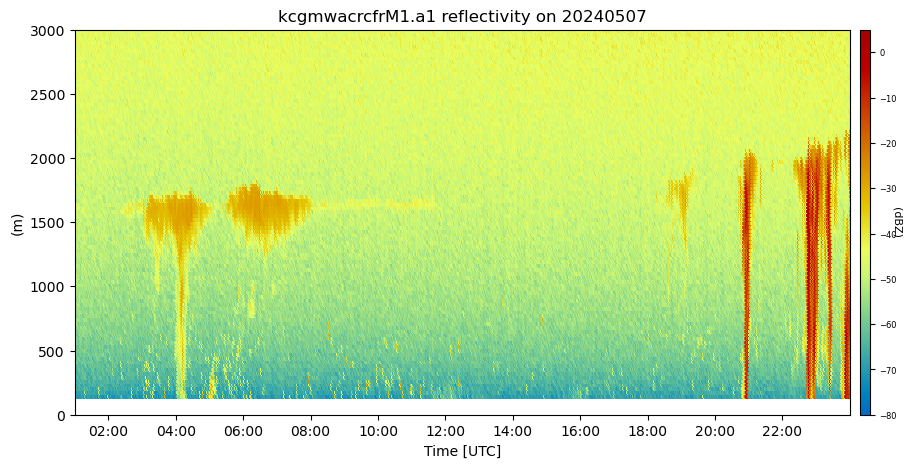

In [34]:
variable = 'reflectivity'
ds_met.clean.cleanup()
display = act.plotting.TimeSeriesDisplay(ds_wacr, figsize=(10, 5), subplot_shape=(1,))

# Plot up the variable in the first plot
display.plot(variable, subplot_index=(0,), cmap='HomeyerRainbow', vmin=-80, vmax=5)
display.set_yrng([0, 3000], subplot_index=(0,))

# Plot up the QC variable in the second plot
#display.qc_flag_block_plot(variable, subplot_index=(1,))
plt.show()

